<a href="https://colab.research.google.com/github/TJConnellyContingentMacro/northwestern/blob/master/GARCH%20Vol_Models_USDJPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Ingest

In [0]:
!pip install arch

In [0]:
!pip install pmdarima

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import arch
from arch import arch_model
#from arch import ConstantMean, GARCH, Normal

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

pd.set_option('display.float_format', lambda x: '%.3f' % x)

import seaborn as sn


In [0]:
import statsmodels.stats as sm_stat
def tsdiag(y, figsize = (14, 8), title = "", lags = 30):
    tmp_data = pd.Series(y)
    #tmp_data.index += 1
    tmp_acor = list(sm_stat.diagnostic.acorr_ljungbox(tmp_data, lags = lags, boxpierce = True))
    # Plot Ljung-Box and Box-Pierce statistic p-values:
    plt.plot(range(1, len(tmp_acor[0]) + 1), tmp_acor[1], 'bo', label = "Ljung-Box values")
    plt.plot(range(1, len(tmp_acor[0]) + 1), tmp_acor[3], 'go', label = "Box-Pierce values")
    plt.xticks(np.arange(1,  len(tmp_acor[0]) + 1, 1.0))
    plt.axhline(y = 0.05, color = "red", label = "5% critical value")
    plt.title("$Time\ Series\ " + title + "$")
    plt.legend()
    plt.show()
    # Return the statistics:
    col_index = ["Ljung-Box: X-squared", "Ljung-Box: p-value", "Box-Pierce: X-squared", "Box-Pierce: p-value"]
    return pd.DataFrame(tmp_acor, index = col_index, columns = range(1, len(tmp_acor[0]) + 1))

This function is for plotting and quick EDA - prefer to use tsdisplay

In [0]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        #scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        pp_ax.hist(y)
        pp_ax.set_title('Histogram')
        plt.tight_layout()
    return 

In [0]:
def tsdisplay(y, figsize = (14, 8), title = "", lags = 20):
    tmp_data = pd.Series(y)
    fig = plt.figure(figsize = figsize)
    #Plot the time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "$Time\ Series\ " + title + "$", legend = False)
    #Plot the ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(323))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = 20, zero = False, ax = fig.add_subplot(324))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the QQ plot of the data:
    sm.qqplot(tmp_data, line='s', ax = fig.add_subplot(325)) 
    plt.title("QQ Plot")
    #Plot the residual histogram:
    fig.add_subplot(326).hist(tmp_data, bins = 40, normed = 1)
    plt.title("Histogram")
    #Fix the layout of the plots:
    plt.tight_layout()
    plt.show()

Data Ingest From:
https://raw.githubusercontent.com/TJConnellyContingentMacro/TimeSeries/




In [0]:
df = pd.read_fwf('https://raw.githubusercontent.com/TJConnellyContingentMacro/TimeSeries/master/d-fxjpus0514.txt')


In [0]:
# from pandas.tseries.offsets import MonthEnd
# df['DATE'] = pd.to_datetime(df['date'], format="%Y%m%d") + MonthEnd(0)
# df['month'] = df['DATE'].dt.strftime('%b')
# df['quarter'] = df['DATE'].dt.quarter

# # this is important to get statsmodels monthplot
# #df = df.asfreq('M')

# df.set_index(df['DATE'], inplace = True)
# df.drop(columns=['date','PERMNO'], inplace = True)
df.rename(columns = {'0.004113024':'JPY'}, inplace = True)
# df.drop(['ba', 'vwretd', 'ewretd', 'DATE'], axis=1, inplace = True)


#DATA WAS ALREADY LOGGED SO I UNLOG IT/EXPONENTIAL

df['JPY'] = np.exp(df['JPY'])

df.describe()

,JPY
count,2209.000
mean,1.000
std,0.007
min,0.949
25%,0.996
50%,1.000
75%,1.004
max,1.034


#**Exploratory Data Analysis**

1.1. Use EDA to justify a transformation of the simple returns to log returns. Is the expected log return zero? Why? Are there any serial correlations in the log returns? Why?


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


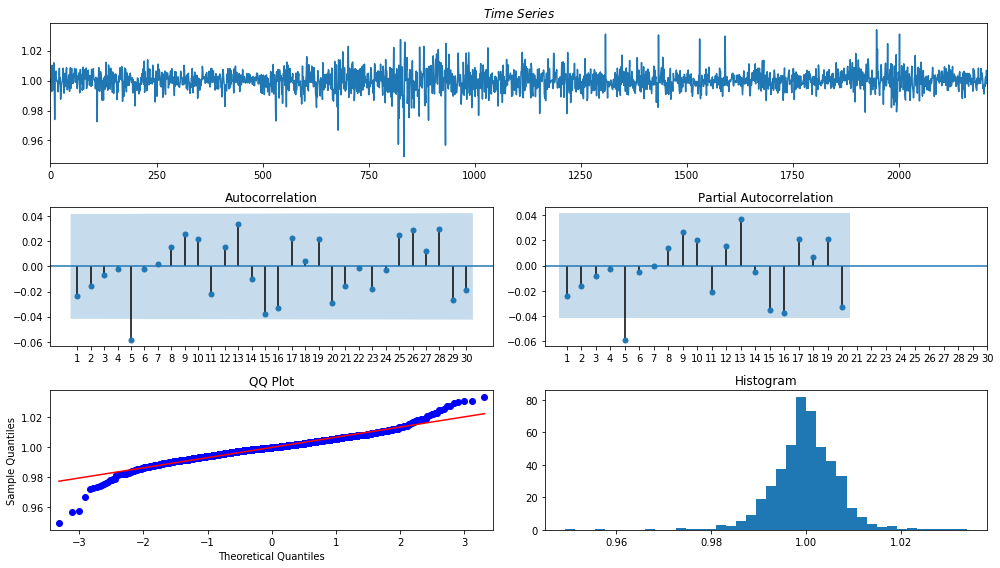

In [0]:
tsdisplay(df['JPY'], lags=30)


In [0]:
df['JPY_EWM'] = df['JPY'].ewm(span=12).mean()

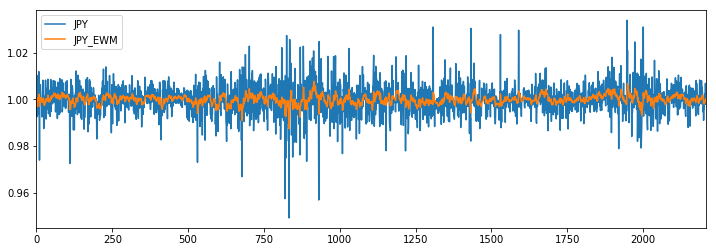

In [0]:
df[['JPY','JPY_EWM']].plot(figsize = (12, 4))

In [0]:
df['JPY'].mean()

0.9999824472423438

In [0]:
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
adf_test(df['JPY'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -22.637
p-value                   0.000
# lags used               4.000
# observations         2204.000
critical value (1%)      -3.433
critical value (5%)      -2.863
critical value (10%)     -2.567
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


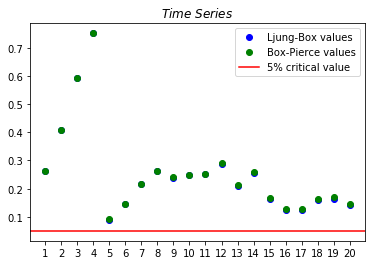

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Ljung-Box: X-squared,1.251,1.792,1.907,1.916,9.519,9.530,9.541,10.055,11.575,12.597,13.689,14.222,16.803,17.042,20.231,22.635,23.780,23.828,24.883,26.743
Ljung-Box: p-value,0.263,0.408,0.592,0.751,0.090,0.146,0.216,0.261,0.238,0.247,0.251,0.287,0.208,0.254,0.163,0.124,0.126,0.161,0.164,0.143
Box-Pierce: X-squared,1.249,1.789,1.904,1.913,9.492,9.503,9.514,10.026,11.538,12.554,13.640,14.170,16.733,16.971,20.135,22.519,23.655,23.702,24.747,26.589
Box-Pierce: p-value,0.264,0.409,0.593,0.752,0.091,0.147,0.218,0.263,0.241,0.250,0.254,0.290,0.212,0.258,0.167,0.127,0.129,0.165,0.169,0.147


In [0]:
tsdiag(df['JPY'], lags = 20)



```
# This is formatted as code
```

# Log of the series

**Now take log of the series**

In [0]:
df['log'] = np.log(df['JPY'] + 1)

In [0]:
df['log'].mean()

0.6931326176872127

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


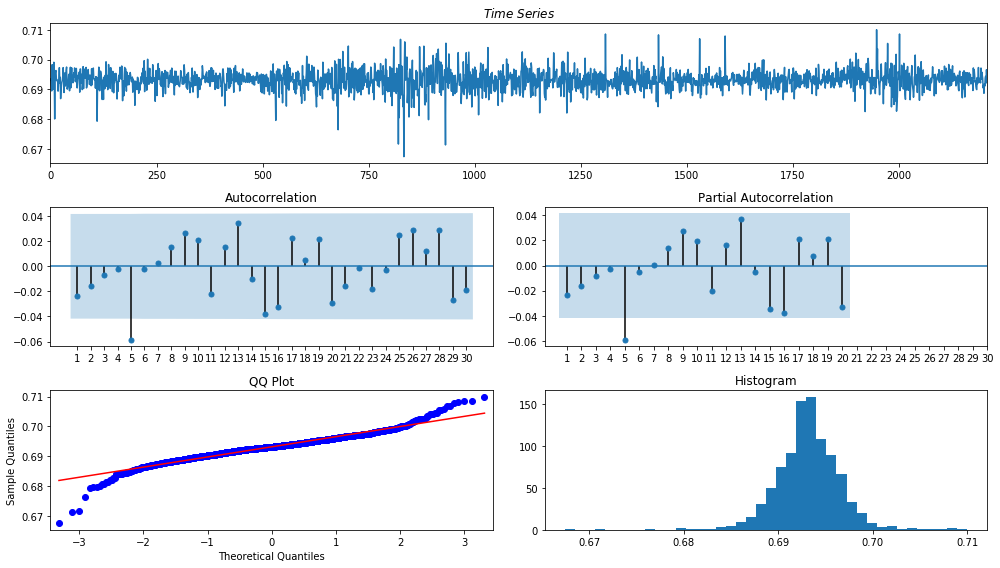

In [0]:
tsdisplay(df['log'], lags=30)

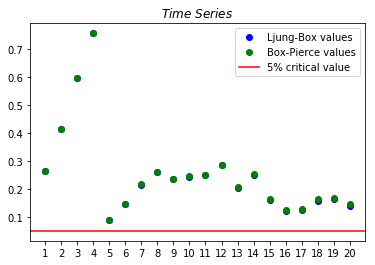

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Ljung-Box: X-squared,1.249,1.768,1.882,1.891,9.548,9.557,9.569,10.075,11.639,12.649,13.724,14.266,16.907,17.135,20.295,22.696,23.843,23.893,24.947,26.837
Ljung-Box: p-value,0.264,0.413,0.597,0.756,0.089,0.145,0.214,0.260,0.234,0.244,0.249,0.284,0.204,0.249,0.161,0.122,0.124,0.159,0.162,0.140
Box-Pierce: X-squared,1.247,1.765,1.879,1.888,9.521,9.530,9.542,10.045,11.601,12.606,13.675,14.214,16.837,17.063,20.198,22.580,23.717,23.767,24.811,26.682
Box-Pierce: p-value,0.264,0.414,0.598,0.756,0.090,0.146,0.216,0.262,0.237,0.247,0.252,0.287,0.207,0.253,0.164,0.125,0.127,0.163,0.167,0.144


In [0]:
tsdiag(df['log'], lags = 20)

#  ARIMA modeling

Quick ARIMA model

In [0]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df['log'],order=(0,0,2))
results = model.fit(trend = 'c')
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                    log   No. Observations:                 2209
Model:                     ARMA(0, 2)   Log Likelihood                9420.772
Method:                       css-mle   S.D. of innovations              0.003
Date:                Tue, 13 Aug 2019   AIC                         -18833.544
Time:                        03:15:10   BIC                         -18810.742
Sample:                             0   HQIC                        -18825.214
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6931   6.94e-05   9980.604      0.000       0.693       0.693
ma.L1.log     -0.0244      0.021     -1.149      0.251      -0.066       0.017
ma.L2.log     -0.0159      0.021     -0.742      0.4

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [0]:
from pmdarima import auto_arima
auto_arima(df['log'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 2209
Model:                     ARMA(0, 0)   Log Likelihood                9419.853
Method:                           css   S.D. of innovations              0.003
Date:                Tue, 13 Aug 2019   AIC                         -18835.706
Time:                        03:15:11   BIC                         -18824.306
Sample:                             0   HQIC                        -18831.541
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6931   7.24e-05   9574.501      0.000       0.693       0.693
==============================================================================
"""

In [0]:
model = ARIMA(df['log'],order=(0,0,0))
results = model.fit()
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                    log   No. Observations:                 2209
Model:                     ARMA(0, 0)   Log Likelihood                9419.853
Method:                           css   S.D. of innovations              0.003
Date:                Tue, 13 Aug 2019   AIC                         -18835.706
Time:                        03:22:55   BIC                         -18824.306
Sample:                             0   HQIC                        -18831.541
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6931   7.24e-05   9574.501      0.000       0.693       0.693


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


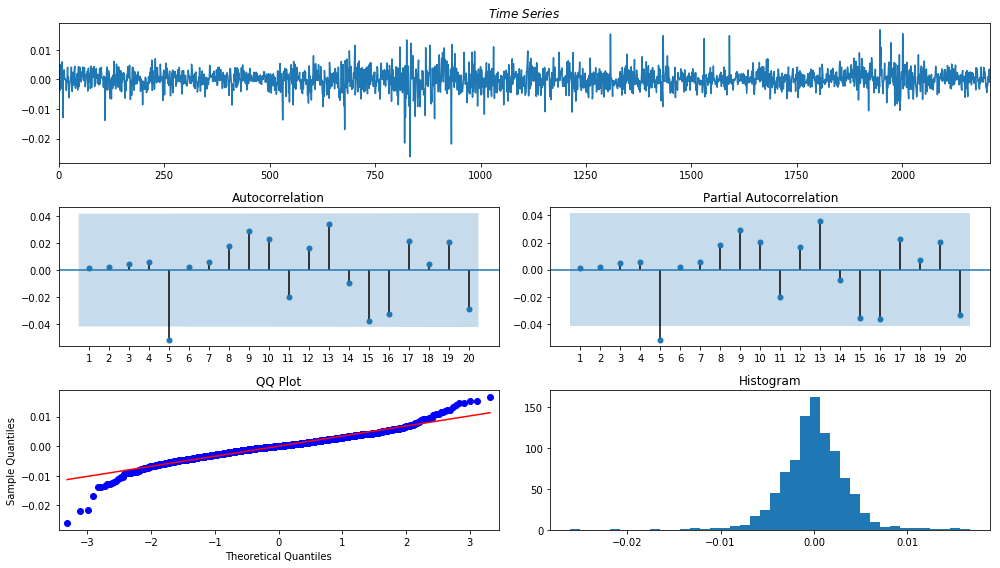

In [0]:
tsdisplay(results.resid)

In [0]:
start=len(df['log'])
end=len(df['log'])+6
predictions = results.predict(start=start, end=end, dynamic=False).rename('ARIMA(1,1) Predictions')

In [0]:
predictions

2209   0.693
2210   0.693
2211   0.693
2212   0.693
2213   0.693
2214   0.693
2215   0.693
Name: ARIMA(1,1) Predictions, dtype: float64

[Text(0, 0.5, 'Chained 2012 Dollars'), Text(0.5, 0, '')]

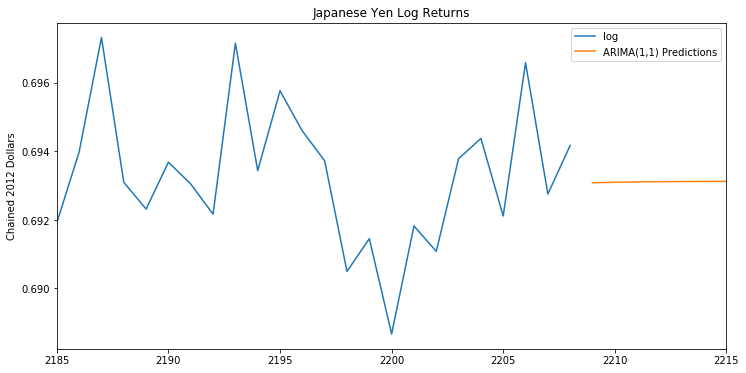

In [0]:
title = 'Japanese Yen Log Returns'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df['log'].tail(24).plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)


In [0]:
df['log'].tail(24)

2185   0.692
2186   0.694
2187   0.697
2188   0.693
2189   0.692
2190   0.694
2191   0.693
2192   0.692
2193   0.697
2194   0.693
2195   0.696
2196   0.695
2197   0.694
2198   0.690
2199   0.691
2200   0.689
2201   0.692
2202   0.691
2203   0.694
2204   0.694
2205   0.692
2206   0.697
2207   0.693
2208   0.694
Name: log, dtype: float64

#GJR-GARCH

https://arch.readthedocs.io/en/latest/univariate/volatility.html

In [0]:
from arch.univariate import GARCH
gjr = GARCH(p=1, o=1, q=1)

In [0]:
MyGJR = arch_model(df['log'],gjr)

In [0]:
res = MyGJR.fit(update_freq=5, disp='off')
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    log   R-squared:                      -0.682
Mean Model:             Constant Mean   Adj. R-squared:                 -0.682
Vol Model:                      GARCH   Log-Likelihood:                8876.98
Distribution:                  Normal   AIC:                          -17746.0
Method:            Maximum Likelihood   BIC:                          -17723.2
                                        No. Observations:                 2209
Date:                Tue, Aug 13 2019   Df Residuals:                     2205
Time:                        03:15:14   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.6959  1.184e-09  5.879e+08      0.000 [  0.696,  0.69

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


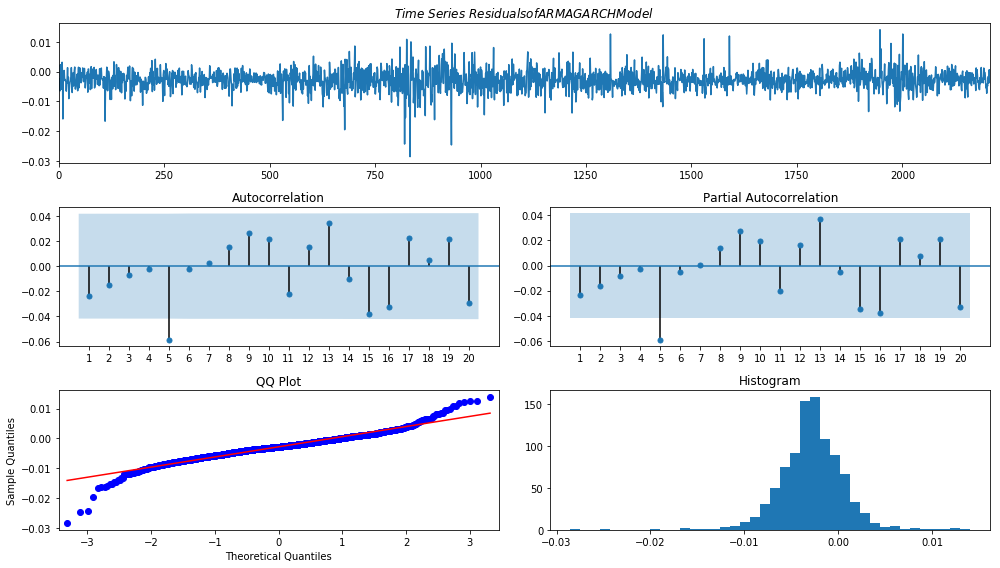

In [0]:
tsdisplay(res.resid, title = "Residuals of ARMA GARCH Model")


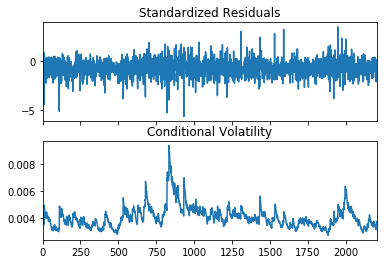

In [0]:
res.plot();

# Let xt = 100rt

This seemed to make the models handle the data better.  GARCH model errors were gone

In [0]:
df['log100'] = df['log']*100

In [0]:
MyGJR = arch_model(df['log100'],gjr)
res = MyGJR.fit(update_freq=5, disp='off')
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 log100   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -624.947
Distribution:                  Normal   AIC:                           1257.89
Method:            Maximum Likelihood   BIC:                           1280.69
                                        No. Observations:                 2209
Date:                Tue, Aug 13 2019   Df Residuals:                     2205
Time:                        03:42:49   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            69.3187  7.130e-03   9722.081      0.000 [ 69.305, 69.33

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


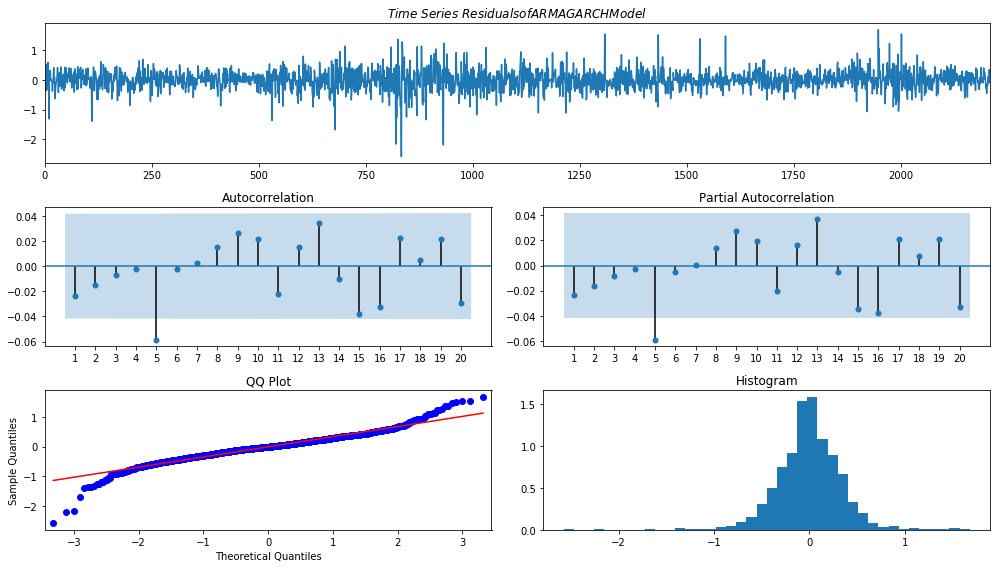

In [0]:
tsdisplay(res.resid, title = "Residuals of ARMA GARCH Model")


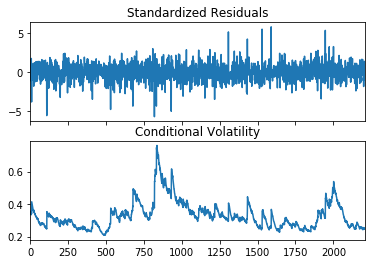

In [0]:
res.plot();